set cuda id

In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

Install dependencies for computing metrics and plots:

In [2]:
#!pip3 install numpy scipy pandas seaborn matplotlib sklearn

## Basic imports

In [3]:
import jax
import jax.numpy as jnp
import flax
from entmax_jax import sparsemax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from sklearn.metrics import roc_auc_score, average_precision_score

from meta_expl.explainers import load_explainer
from meta_expl.models import load_model
from meta_expl.data.mlqe import dataloader

from evaluate_explanations import evaluate_word_level, evaluate_sentence_level, aggregate_pieces

In [30]:
# data utils
def unroll(list_of_lists):
    return [e for ell in list_of_lists for e in ell]

def read_data(lp, split='dev'):
    def tags_to_ints(line):
        return list(map(int, line.strip().replace('OK', '0').replace('BAD', '1').split()))
    data = {
        'original': [line.strip() for line in open('data/{}/{}.src'.format(lp, split), 'r')],
        'translation': [line.strip() for line in open('data/{}/{}.mt'.format(lp, split), 'r')],
        'da': [float(line.strip()) for line in open('data/{}/{}.da'.format(lp, split), 'r')],
        'src_tags': [tags_to_ints(line) for line in open('data/{}/{}.src-tags'.format(lp, split), 'r')],
        'mt_tags': [tags_to_ints(line) for line in open('data/{}/{}.tgt-tags'.format(lp, split), 'r')]
    }
    z = np.array(data['da'])
    data['z_mean'] = (z - z.mean()) / z.std()
    data = [dict(zip(data.keys(), v)) for v in list(zip(*data.values()))]
    return data

## Define args and load stuff

In [38]:
# arguments
arch = 'xlm-roberta-base'
arch_mtl = 'xlm-r'
setup = 'no_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"
lp = 'et-en'
max_len = 256
batch_size = 16
seed = 1
sep_token = "</s>" if 'xlm' in arch else "[SEP]"
num_classes = 1
task_type = "regression"
teacher_dir = 'data/mlqe-xlmr-explainer/teacher_dir'
explainer_dir = 'data/mlqe-xlmr-explainer/teacher_expl_dir'

In [39]:
# create dummy inputs for model instantiation
input_ids = jnp.ones((batch_size, max_len), jnp.int32)
dummy_inputs = {
    "input_ids": input_ids,
    "attention_mask": jnp.ones_like(input_ids),
    "token_type_ids": jnp.arange(jnp.atleast_2d(input_ids).shape[-1]),
    "position_ids": jnp.ones_like(input_ids),
}
dummy_inputs['input_ids'].shape

(16, 256)

### load data

In [40]:
# load data
dataloader = partial(dataloader, sep_token=sep_token)
train_data = read_data(lp, "train")
valid_data = read_data(lp, "dev")

### load tokenizer

In [41]:
from transformers import XLMRobertaTokenizerFast
tokenizer = XLMRobertaTokenizerFast.from_pretrained(arch)
cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

### load model and explainer

In [42]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(explainer_dir, dummy_inputs, state=dummy_state)

### look at the coefficients

In [60]:
sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)

DeviceArray([[6.6099882e-02, 6.3712515e-02, 7.3839456e-02, 6.9502227e-02,
              5.1050484e-02, 9.5809259e-02, 5.9452578e-02, 6.5691888e-02,
              1.2076387e-02, 2.8657366e-02, 4.7833547e-02, 6.7266285e-02],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
              0.0000000e+00, 0.000

In [69]:
# check the layers with the highest coefficients
layer_coeffs = sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12).sum(-1).tolist()
sorted(list(zip(list(range(0, len(layer_coeffs))), layer_coeffs)), key=lambda k: k[1])

[(1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (5, 0.0),
 (6, 0.0),
 (11, 0.0),
 (10, 0.01255672238767147),
 (8, 0.033780381083488464),
 (9, 0.033964600414037704),
 (4, 0.05198308825492859),
 (7, 0.16672329604625702),
 (0, 0.7009918689727783)]

## Get explanations

In [76]:
def get_explanations(data, strategy='mtl', layer_id=0, head_id=0):
    all_tokens = []
    all_masks = []
    all_explanations = []
    all_outputs = []
    c = 1
    for x, y in dataloader(data, tokenizer, batch_size=batch_size, max_len=max_len, shuffle=False):
        print('{} of {}'.format(c, len(data) // batch_size + 1), end='\r')
        c += 1
        
        # get teacher output
        y_teacher, teacher_attn = teacher.apply(teacher_params, **x, deterministic=True)
        if task_type == "classification":
            y_teacher = jnp.argmax(y_teacher, axis=-1)
        
        # use the explanation given to the student by the teacher explainer
        if strategy == 'mtl':
            # get explanation from the teacher explainer
            teacher_expl, _ = teacher_explainer.apply(teacher_explainer_params, x, teacher_attn)
        
        # use the explanation from the best head at the best layer (according to the coefficients)
        elif strategy == 'top_layer_head':
            # batch x layers x heads x seqlen x seqlen
            all_attentions = jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4])
            num_layers = all_attentions.shape[1] 
            num_heads = all_attentions.shape[2]

            # get the attention from the teacher associated with the top head coeff
            head_coeffs = sparsemax(teacher_explainer_params['params']['head_coeffs'])
            top_joint_id = jnp.argmax(head_coeffs).item()
            top_layer_id = top_joint_id // num_heads
            top_head_id = top_joint_id % num_heads
            attn = all_attentions[:, top_layer_id, top_head_id]
            mask = x['attention_mask']
            teacher_expl = (attn * mask[:, :, None]).sum(-2) / mask.sum(-1)[:, None]
        
        # average a specific layer
        elif strategy == 'layer_average':
            all_attentions = jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4])
            attn = all_attentions[:, layer_id].mean(1)
            mask = x['attention_mask']
            teacher_expl = (attn * mask[:, :, None]).sum(-2) / mask.sum(-1)[:, None]
        
        # use a specific head at a specific layer
        elif strategy == 'layer_head':
            all_attentions = jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4])
            attn = all_attentions[:, layer_id, head_id]
            mask = x['attention_mask']
            teacher_expl = (attn * mask[:, :, None]).sum(-2) / mask.sum(-1)[:, None]
        
        # return all nonzero attention explanations (not tested)
        else:
            # get all attentions from the teacher associated with nonzero head coeff
            head_coeffs = head_coeffs.reshape(num_layers, num_heads)
            nonzero_rows, nonzero_cols = head_coeffs.nonzero()
            num_nonzero = len(nonzero_rows)
            attn = jnp.stack([
                all_attentions[:, r, c] for r, c in zip(nonzero_rows.tolist(), nonzero_cols.tolist())
            ]).transpose([1, 0, 2, 3])  # batch, num_nonzero, seqlen, seqlen
            mask = x['attention_mask']
            teacher_expl = (attn * mask[..., None]).sum(-2) / mask.sum(-1)[..., None]

        # convert everything to lists
        batch_ids = x['input_ids'].tolist()
        batch_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in batch_ids]
        batch_masks = [[tk.startswith('▁') for tk in tokens] for tokens in batch_tokens]
        batch_expls = teacher_expl.tolist()
        
        # filter out pad
        batch_valid_len = x['attention_mask'].sum(-1).tolist()
        for i in range(len(batch_valid_len)):
            n = batch_valid_len[i]
            batch_ids[i] = batch_ids[i][:n]
            batch_tokens[i] = batch_tokens[i][:n]
            batch_masks[i] = batch_masks[i][:n]
            batch_expls[i] = batch_expls[i][:n]
        
        all_tokens.extend(batch_tokens)
        all_masks.extend(batch_masks)
        all_explanations.extend(batch_expls)
        all_outputs.extend(y_teacher.tolist())

    return all_tokens, all_masks, all_explanations, all_outputs

In [78]:
valid_tokens, valid_masks, valid_explanations, valid_outputs = get_explanations(
    valid_data, strategy='mtl'
)
list(map(len, [valid_tokens, valid_masks, valid_explanations, valid_outputs]))

[1000, 1000, 1000, 1000]

### Aggregate scores for word pieces in SRC and MT independently

In [79]:
import torch
from utils import aggregate_pieces

def get_src_and_mt_explanations(all_tokens, all_fp_masks, all_explanations, reduction):
    src_expls = []
    mt_expls = []
    src_pieces = []
    mt_pieces = []
    for tokens, expl, fp_mask in zip(all_tokens, all_explanations, all_fp_masks):
        # split data into src and mt (assuming "<s> src </s> mt </s>" format without CLS for mt) 
        src_len = tokens.index(tokenizer.sep_token) + 1
        src_tokens, mt_tokens = tokens[:src_len], tokens[src_len:]
        src_expl, mt_expl = expl[:src_len], expl[src_len:]
        src_fp_mask, mt_fp_mask = fp_mask[:src_len], fp_mask[src_len:]
        
        # aggregate word pieces scores (use my old good torch function)
        agg_src_expl = aggregate_pieces(torch.tensor(src_expl), torch.tensor(src_fp_mask), reduction)
        agg_mt_expl = aggregate_pieces(torch.tensor(mt_expl), torch.tensor(mt_fp_mask), reduction)
        
        # remove <s> and </s> from src
        agg_src_expl = agg_src_expl.tolist()[1:-1]
        # remove </s> from mt
        agg_mt_expl = agg_mt_expl.tolist()[:-1]
        
        src_pieces.append(src_tokens)
        mt_pieces.append(mt_tokens)
        src_expls.append(agg_src_expl)
        mt_expls.append(agg_mt_expl)
    return src_expls, mt_expls, src_pieces, mt_pieces

In [80]:
reduction = 'sum'
src_expls, mt_expls, src_pieces, mt_pieces = get_src_and_mt_explanations(
    valid_tokens, valid_masks, valid_explanations, reduction=reduction
)

## Evaluating explanations by comparing explanations with word-level QE tags

In [81]:
# simulating predictions
gold_src_tokens = [inp['original'].split() for inp in valid_data]
gold_mt_tokens = [inp['translation'].split() for inp in valid_data]
gold_expls_src = [inp['src_tags'] for inp in valid_data]
gold_expls_mt = [inp['mt_tags'] for inp in valid_data]
gold_scores = [inp['z_mean'] for inp in valid_data]

pred_expls_src = src_expls
pred_expls_mt = mt_expls
pred_scores = unroll(valid_outputs)

In [82]:
_ = evaluate_sentence_level(gold_scores, pred_scores)

Pearson: 0.6343
Spearman: 0.6369
MAE: 0.6692
RMSE: 0.8001


In [83]:
_ = evaluate_word_level(gold_expls_src, pred_expls_src)

AUC score: 0.6343
AP score: 0.5172
Recall at top-K: 0.3914


In [84]:
_ = evaluate_word_level(gold_expls_mt, pred_expls_mt)

AUC score: 0.6094
AP score: 0.4875
Recall at top-K: 0.3731


## Visualizing explanations

In [51]:
def detokenize(pieces):
    return ''.join(pieces).replace('▁', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, label='GOLD', max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(0, 255, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(255, 0, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array / color_array.abs().max()):
        if color >= 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="100%">{}:&nbsp;&nbsp; {}</div>'.format(label, colored_string)
    display(HTML(html_text))

def show_explanation(tokens, tags, explanation):
    import torch
    colorize_twoway(tokens.split(), torch.tensor(tags), label='gold')
    colorize_twoway(tokens.split(), torch.tensor(explanation), label='pred')

In [52]:
idx = 0
print('SRC:')
print('----')
show_explanation(valid_data[idx]['original'], gold_expls_src[idx], pred_expls_src[idx])
print('MT:')
print('----')
show_explanation(valid_data[idx]['translation'], gold_expls_mt[idx], pred_expls_mt[idx])

SRC:
----


MT:
----


## Plotting the distribution of predictions and AUC scores

In [53]:
# define options for seaborn
custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.color': '.85',
    'grid.linestyle': ':'
}
_ = sns.set_theme(style='whitegrid', rc=custom_params),

def plot_da_vs_expl_metric(metric_fn, das, e_golds, e_preds):
    x = []
    y = []
    for da, gold, pred in zip(das, e_golds, e_preds):
        if sum(gold) == 0 or sum(gold) == len(gold):
            continue
        y.append(metric_fn(gold, pred))
        x.append(da)
    x = np.array(x)
    y = np.array(y)
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.histplot(x=x, y=y, ax=axs[0])
    axs[0].set_xlabel('da')
    axs[0].set_ylabel(str(metric_fn).split()[1])
    sns.histplot(x, bins=20, ax=axs[1])
    axs[1].set_xlabel('da')
    sns.histplot(y, bins=20, ax=axs[2])
    axs[2].set_xlabel(str(metric_fn).split()[1])

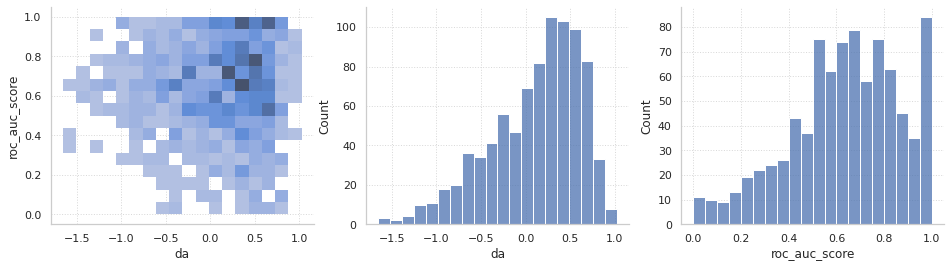

In [54]:
# plot predicted DA vs AUC for src and mt
plot_da_vs_expl_metric(roc_auc_score, pred_scores, gold_expls_src, pred_expls_src)

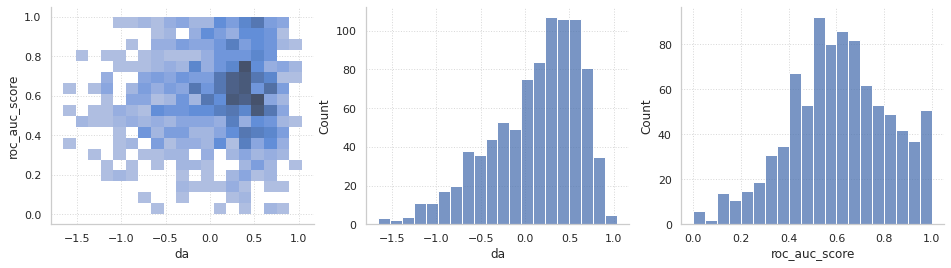

In [55]:
plot_da_vs_expl_metric(roc_auc_score, pred_scores, gold_expls_mt, pred_expls_mt)

## Plotting attention map

In [ ]:
# dummy code, just to exemplify
fig, axs = plt.subplots(2, 3, figsize=(16, 11))
fig.tight_layout(pad=3)
for i in range(6):
    ax = axs[i//3, i%3]
    tokens = valid_data[i]['translation'].split()
    n = len(tokens)
    softmax = lambda x: np.exp(x) / np.exp(x).sum()
    A = np.stack([softmax(np.random.randn(n)) for _ in range(n)])
    df = pd.DataFrame(A, columns=tokens, index=tokens)
    sns.heatmap(df, vmax=1, cmap="Greens", square=True, cbar=False, ax=ax)

## Check results for all layers (slooow -> very inefficient)

In [77]:
for layer_id in range(12):
    valid_tokens, valid_masks, valid_explanations, valid_outputs = get_explanations(
        valid_data, strategy='layer_average', layer_id=layer_id
    )
    src_expls, mt_expls, src_pieces, mt_pieces = get_src_and_mt_explanations(
        valid_tokens, valid_masks, valid_explanations, reduction='sum'
    )
    print('LAYER: {}'.format(layer_id))
    _ = evaluate_word_level(gold_expls_src, src_expls)
    _ = evaluate_word_level(gold_expls_mt, mt_expls)
    print('---')

LAYER: 0
AUC score: 0.5017
AP score: 0.4072
Recall at top-K: 0.2793
AUC score: 0.4502
AP score: 0.3441
Recall at top-K: 0.2530
---
LAYER: 1
AUC score: 0.4424
AP score: 0.3761
Recall at top-K: 0.2511
AUC score: 0.4416
AP score: 0.3633
Recall at top-K: 0.2625
---
LAYER: 2
AUC score: 0.4085
AP score: 0.3610
Recall at top-K: 0.2340
AUC score: 0.4583
AP score: 0.3726
Recall at top-K: 0.2742
---
LAYER: 3
AUC score: 0.3710
AP score: 0.3462
Recall at top-K: 0.2210
AUC score: 0.4306
AP score: 0.3584
Recall at top-K: 0.2589
---
LAYER: 4
AUC score: 0.4496
AP score: 0.3777
Recall at top-K: 0.2483
AUC score: 0.5065
AP score: 0.4023
Recall at top-K: 0.3000
---
LAYER: 5
AUC score: 0.4149
AP score: 0.3617
Recall at top-K: 0.2365
AUC score: 0.4964
AP score: 0.3944
Recall at top-K: 0.2975
---
LAYER: 6
AUC score: 0.4155
AP score: 0.3673
Recall at top-K: 0.2405
AUC score: 0.5363
AP score: 0.4277
Recall at top-K: 0.3334
---
LAYER: 7
AUC score: 0.4179
AP score: 0.3525
Recall at top-K: 0.2269
AUC score: 0.53

## Check results for all heads in all layers (I'm not even going to try this)

In [ ]:
for layer_id in range(12):
    for head_id in range(12):
        valid_tokens, valid_masks, valid_explanations, valid_outputs = get_explanations(
            valid_data, strategy='layer_head', layer_id=layer_id, head_id=head_id
        )
        src_expls, mt_expls, src_pieces, mt_pieces = get_src_and_mt_explanations(
            valid_tokens, valid_masks, valid_explanations, reduction='sum'
        )
        print('LAYER: {} | HEAD: {}'.format(layer_id, head_id))
        _ = evaluate_word_level(gold_expls_src, src_expls)
        _ = evaluate_word_level(gold_expls_mt, mt_expls)
        print('---')